# Intro

In [0]:
!pip install tensorflow==2.0.0-rc1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
print(tf.__version__)

2.0.0-rc1


In [0]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [0]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.06
c_reg2=0.0003
d=4

In [0]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

# Initial condition

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.9524267897002403>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.8810606760563969>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.043230475380620526>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.16099004109249437>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.13550894, 2.5213582 , 0.887006  , 2.11582096, 1.61006894,
       0.66690719, 2.92128631, 1.52205281, 3.65567615, 3.71652142])>


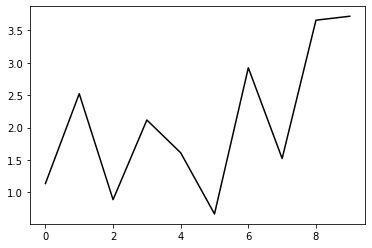

In [6]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

# Data generation

[ 1.59046380e-05 -6.81729619e-04  1.31412783e-02 -1.50525122e-01
  1.14052764e+00 -6.02241589e+00  2.27455146e+01 -6.20704637e+01
  1.22166909e+02 -1.71187057e+02  1.66428939e+02 -1.07461541e+02
  4.28229849e+01 -9.20544844e+00  9.55260214e-01 -1.30925094e-04]


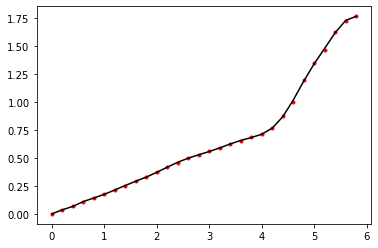

In [7]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [0]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

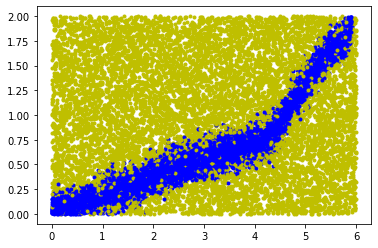

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [0]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

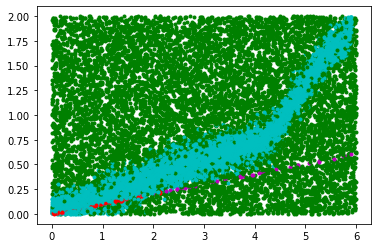

In [11]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [0]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)**2
    NNlist=(1-t_func(M_1))**2
    sum_p=sum(PPlist)/batch
    sum_n=sum(NNlist)/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [13]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.2978480242962032, shape=(), dtype=float64)
tf.Tensor(1.2988820363448605, shape=(), dtype=float64)
tf.Tensor(1.304211432719362, shape=(), dtype=float64)
tf.Tensor(1.2939289909415244, shape=(), dtype=float64)
tf.Tensor(1.2942201711889594, shape=(), dtype=float64)
tf.Tensor(1.2939579704496367, shape=(), dtype=float64)
tf.Tensor(1.3042199552442286, shape=(), dtype=float64)
tf.Tensor(1.2839111952962683, shape=(), dtype=float64)
tf.Tensor(1.284827590320238, shape=(), dtype=float64)
tf.Tensor(1.284072136658715, shape=(), dtype=float64)
tf.Tensor(1.3140899639980723, shape=(), dtype=float64)
tf.Tensor(1.3138781360977527, shape=(), dtype=float64)
tf.Tensor(1.2945763195539108, shape=(), dtype=float64)
tf.Tensor(1.2942199657754598, shape=(), dtype=float64)
tf.Tensor(1.3227011761701053, shape=(), dtype=float64)
tf.Tensor(1.2944290937169227, shape=(), dtype=float64)
tf.Tensor(1.3142184375230148, shape=(), dtype=float64)
tf.Tensor(1.3126271543861374, shape=(), dtype=float64)
tf.Tensor(1.2

# Optimize

In [14]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

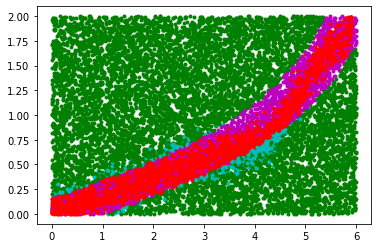

In [18]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

99990 0.1678233920768393
0.2248222709715585 -0.5715725768207749 -0.13423571097789536 -0.06557628959646469
[ 1.25517366  1.26000667  1.18703731  1.07948957  0.92028954  0.67761648
  0.33459915 -0.10752849 -0.15037286  7.55451461]


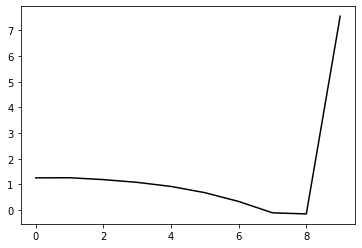

([<matplotlib.lines.Line2D at 0x7f6e262ddb00>], None)

In [19]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()